In [1]:
import numpy as np
from matplotlib import pyplot as plt

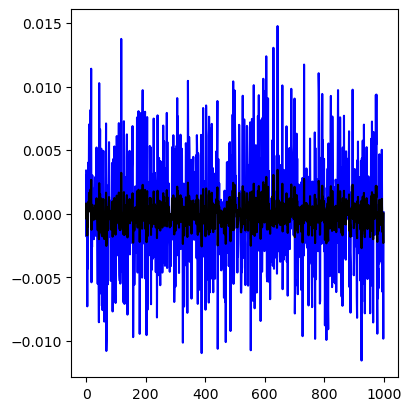

In [31]:
a = np.random.randn()
b = np.random.randn()
eps = 0.001

def next(a, b, w, x, eps):
    next_u = w * x
    next_x = a * x + next_u * b + eps * np.random.randn()
    return next_x, next_u

def wstar(u, x, k, t):
    first_sum = 0 
    next_sum = 0
    cos_x = 0
    for tau in range(t - 1, t - k, -1):
        if tau >= 0:
            first_sum += u[tau] * x[tau]
            next_sum -= u[tau] * x[tau + 1]
            cos_x += x[tau] * x[tau + 1] / (x[tau + 1] * x[tau + 1])
    return first_sum + cos_x * next_sum


T = 1000
x = np.zeros(T)
u = np.zeros(T)
w = np.zeros(T)
x[0] = np.random.randn() * eps

optimal_w = True
if optimal_w:
    w = -a / b + 0
else:
    w[0] = np.random.randn()

for t in range(T):
    next_x, next_u = next(a, b, w, x[t], eps)
    u[t] = next_u
    if t < (T - 1):
        x[t + 1] = next_x
        # w[t + 1] = wstar(u, x, 1000, t)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
ax.plot(range(T), u, color="b")
ax.plot(range(T), x, color="k")
plt.show()

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def generate_run(sigmau, standard_ab=True):
    """
    Generate two realizations (with and without noise) of the closed-loop DD-DC system.

    Parameters
    ----------
    sigmau : float
        Amplitude of the additive white noise in the control signal.
    standard_ab : bool
        If True, use standard values for a and b.

    Returns
    -------
    dict
        Dictionary containing state, control, gain, and loss trajectories for both
        noiseless and noisy control scenarios, as well as critical parameters.
    """
    rq = 0
    iswitch = 25
    ijolt = 55
    run = 100
    pre = 4
    gamma = 0.5
    sigmax = 0

    if standard_ab:
        a0 = 1.1
        a1 = 1.3
        b0 = 1.0
        b1 = 0.5
    else:
        a0 = np.abs(np.random.randn())
        a1 = np.abs(np.random.randn())
        b0 = np.abs(np.random.randn())
        b1 = np.abs(np.random.randn())

    a = np.concatenate([a0 * np.ones(iswitch), a1 * np.ones(run - iswitch)])
    b = np.concatenate([b0 * np.ones(iswitch), b1 * np.ones(run - iswitch)])
    jolt = np.zeros(run)
    jolt[ijolt] = 0.2

    wstab1 = (1 - a) / b
    wstab2 = -(1 + a) / b
    wopt = -a / b

    x0 = 0.1 * np.random.randn()
    xnoise = sigmax * np.random.randn(run)
    unoise = sigmau * np.random.randn(run)

    result_with_noise = simulate_dynamics(a, b, x0, xnoise, unoise, jolt, run, pre, rq, gamma)
    result_without_noise = simulate_dynamics(a, b, x0, xnoise, np.zeros(run), jolt, run, pre, rq, gamma, upre=result_with_noise['u'][:pre])
    result_with_silencing = simulate_dynamics(a, b, x0, xnoise, np.zeros(run), jolt, run, pre, rq, gamma, silencing=True)

    return {
        'nonoise_x': result_without_noise['x'],
        'nonoise_u': result_without_noise['u'],
        'nonoise_w': result_without_noise['w'],
        'nonoise_loss': result_without_noise['loss'],
        'noise_x': result_with_noise['x'],
        'noise_u': result_with_noise['u'],
        'noise_w': result_with_noise['w'],
        'noise_loss': result_with_noise['loss'],
        'silencing_x': result_with_silencing['x'],
        'silencing_u': result_with_silencing['u'],
        'silencing_w': result_with_silencing['w'],
        'silencing_loss': result_with_silencing['loss'],
        'ijolt': ijolt,
        'iswitch': iswitch,
        'wopt': wopt,
        'wstab1': wstab1,
        'wstab2': wstab2
    }

def simulate_dynamics(a, b, x0, xnoise, unoise, jolt, run, pre, rq, gamma, upre=None, silencing=False):
    x = np.full(run, np.nan)
    u = np.full(run, np.nan)
    w = np.full(run, np.nan)
    xp = np.full(run, np.nan)
    xcur = x0

    output_scaling = 0.0 if silencing else 1.0

    if upre is None:
        upre = 0.01 * np.random.randn(pre)

    u[:pre] = upre
    for i in range(pre):
        x[i] = xcur
        xp[i] = a[i] * xcur + output_scaling * b[i] * u[i] + xnoise[i]
        xcur = xp[i]

    mem = {
        'uu': np.dot(u[:pre], u[:pre]),
        'ux': np.dot(u[:pre], x[:pre]),
        'uz': np.dot(u[:pre], xp[:pre]),
        'xx': np.dot(x[:pre], x[:pre]),
        'xz': np.dot(x[:pre], xp[:pre]),
        'zz': np.dot(xp[:pre], xp[:pre]),
    }
    mem0 = mem.copy()

    for i in range(pre, run):
        w[i] = get_w_by_mem(mem, rq)
        x[i] = xcur
        u[i] = w[i] * x[i] + unoise[i]
        xp[i] = a[i] * x[i] + b[i] * u[i] + xnoise[i] + jolt[i]
        xcur = xp[i]
        mem = update_mem(mem, u[i], x[i], xp[i], gamma)

    loss = xp**2 + rq * u**2
    return {'x': x, 'u': u, 'w': w, 'loss': loss}

def get_w_by_mem(mem, rq):
    """
    Compute optimal gain using Eq. 10.
    """
    uu = mem['uu']
    ux = mem['ux']
    uz = mem['uz']
    xx = mem['xx']
    xz = mem['xz']
    zz = mem['zz']
    
    numerator = ux * zz - xz * uz
    denominator = zz * xx - xz**2 + rq * uu * xx - rq * ux**2
    return numerator / denominator if denominator != 0 else 0

def update_mem(mem, u, x, z, gamma):
    """
    Update covariance estimates using exponential moving average.
    """
    mem['uu'] = gamma * mem['uu'] + (1 - gamma) * u * u
    mem['ux'] = gamma * mem['ux'] + (1 - gamma) * u * x
    mem['uz'] = gamma * mem['uz'] + (1 - gamma) * u * z
    mem['xx'] = gamma * mem['xx'] + (1 - gamma) * x * x
    mem['xz'] = gamma * mem['xz'] + (1 - gamma) * x * z
    mem['zz'] = gamma * mem['zz'] + (1 - gamma) * z * z
    return mem

def plot_run_results(results):
    t = np.arange(len(results['nonoise_x']))
    ijolt = results['ijolt']
    iswitch = results['iswitch']
    
    def add_annotations(ax, ylabel):
        ax.axvline(ijolt, color='red', linestyle='--', label='Jolt')
        ax.axvline(iswitch, color='black', linestyle='--', label='Switch')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True)

    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    # State x
    axs[0].plot(t, results['nonoise_x'], label='No Noise', linewidth=2)
    axs[0].plot(t, results['noise_x'], label='Noise', linestyle='--', linewidth=2)
    axs[0].plot(t, results['silencing_x'], label='Silencing', linestyle=':', linewidth=2)
    axs[0].set_title('System State $x_t$')
    add_annotations(axs[0], '$x_t$')

    # Control u
    axs[1].plot(t, results['nonoise_u'], label='No Noise', linewidth=2)
    axs[1].plot(t, results['noise_u'], label='Noise', linestyle='--', linewidth=2)
    axs[1].plot(t, results['silencing_u'], label='Silencing', linestyle=':', linewidth=2)
    axs[1].set_title('Control Signal $u_t$')
    add_annotations(axs[1], '$u_t$')

    # Gain w
    axs[2].plot(t, results['nonoise_w'], label='No Noise', linewidth=2)
    axs[2].plot(t, results['noise_w'], label='Noise', linestyle='--', linewidth=2)
    axs[2].plot(t, results['silencing_w'], label='Silencing', linestyle=':', linewidth=2)
    axs[2].plot(t, results['wopt'], label='Optimal $w$', linestyle='-.', linewidth=1.5)
    axs[2].fill_between(t, results['wstab1'], results['wstab2'], color='gray', alpha=0.3, label='Stability Region')
    axs[2].set_title('Adaptive Gain $w_t$')
    add_annotations(axs[2], '$w_t$')

    # Loss
    axs[3].plot(t, results['nonoise_loss'], label='No Noise', linewidth=2)
    axs[3].plot(t, results['noise_loss'], label='Noise', linestyle='--', linewidth=2)
    axs[3].plot(t, results['silencing_loss'], label='Silencing', linestyle=':', linewidth=2)
    axs[3].set_title('Control Loss')
    add_annotations(axs[3], 'Loss')

    axs[3].set_xlabel('Time Step $t$')
    plt.tight_layout()
    plt.show()


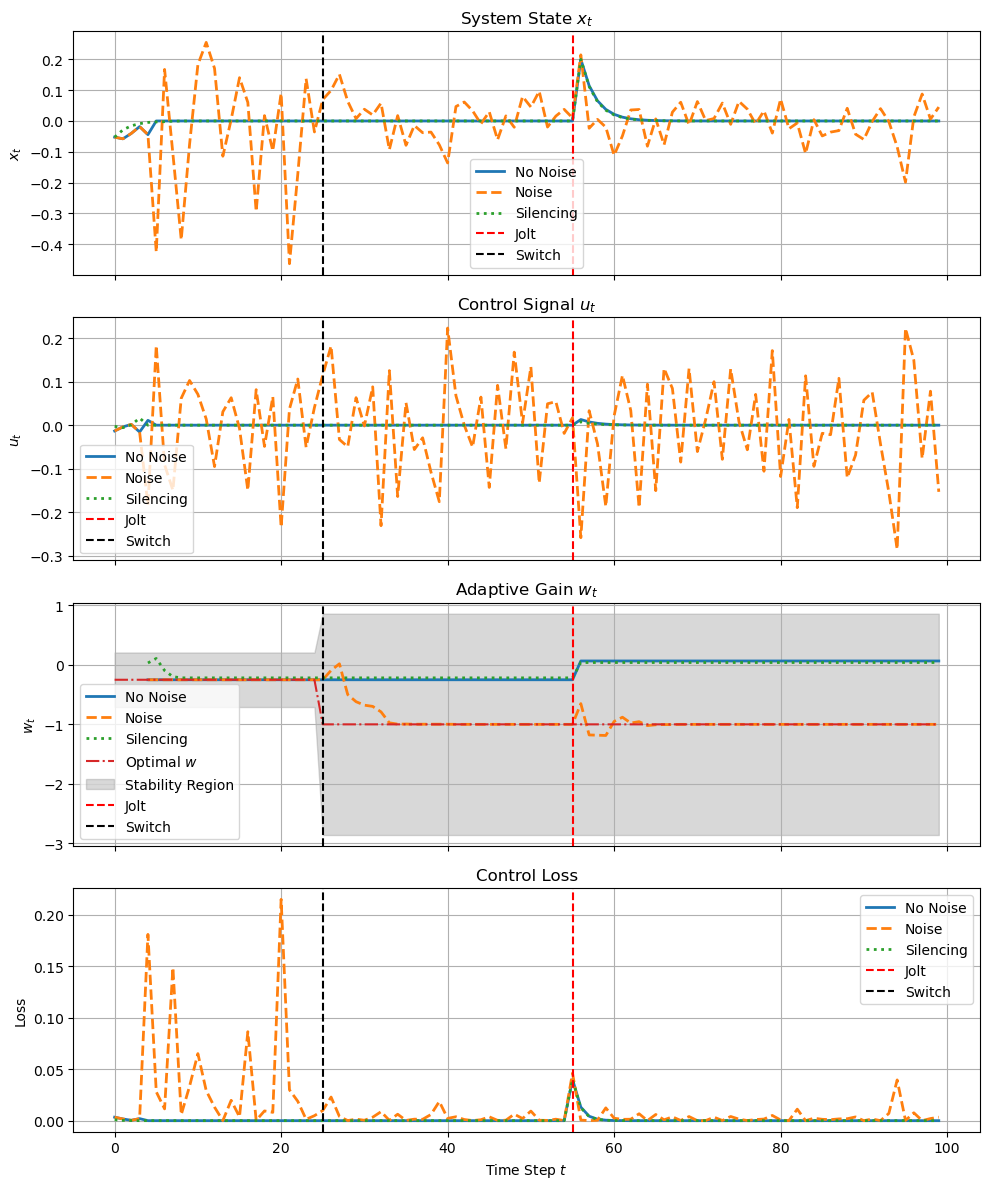

In [51]:
results = generate_run(0.1, standard_ab=False)
plot_run_results(results)